<a href="https://colab.research.google.com/github/MarcLefevreFr/OpenClassrooms/blob/master/P6_ml_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Préliminaires**<br>**Import :**<br>- google drive<br>- données<br>- bibliothèques python

In [4]:
# instal google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# récupe des zip d'images et extractions
import shutil
import os
import zipfile
from time import time

start = time()
cwd = os.getcwd()

shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "test.zip"), cwd)
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "train.zip"), cwd)

# données "low" = image originales mais juste les 30 première classes
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "test_light.zip"), cwd)
shutil.copy(os.path.join("drive/MyDrive/P6/Data/", "train_light.zip"), cwd)



with zipfile.ZipFile(cwd + "/test.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/train.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/test_light.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

with zipfile.ZipFile(cwd + "/train_light.zip", 'r') as zip_ref :
    zip_ref.extractall(cwd)

print(f"Import & extraction des data : {time()-start:.0f} secondes.")

Import & extraction des data : 78 secondes.


In [6]:
# vérif
import os
# chemin des répertoires contenant les photos
PATH_TRAIN = "train"
PATH_TRAIN_l = "train_light"
PATH_TEST = "test"
PATH_TEST_l = "test_light"

len(os.listdir(PATH_TRAIN)), len(os.listdir(PATH_TEST)), len(os.listdir(PATH_TRAIN_l)), len(os.listdir(PATH_TEST_l))

(120, 120, 30, 30)

In [45]:
# Import python
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import PIL.ImageOps as ops
import os
import pickle
import random as rd
from time import time

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Fonctions utiles**

In [25]:
def modelize(model, nb_epochs, train_gen, val_gen, train_steps, val_steps, mod_name, opti = "adam", verbose = 0):

    model.compile(loss='categorical_crossentropy',
                  optimizer = opti,
                  metrics=['accuracy', ])

    start = time()

    history = model.fit(train_gen,
                        steps_per_epoch = train_steps,
                        epochs = nb_epochs,
                        validation_data = val_gen,
                        validation_steps = val_steps,
                        verbose = verbose)
    
    model.save_weights("drive/MyDrive/P6/Data/models/" + mod_name + ".h5")
    pickle.dump(history.history, open("drive/MyDrive/P6/Data/models/" + mod_name + "_hist.pickle", "wb" ))

    fig = plt.figure(figsize = (10,4))

    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    
    plt.plot(range(1, nb_epochs+1), train_acc, 'b', label='Train acc', color = "red")
    plt.plot(range(1, nb_epochs+1), val_acc, 'b', label='Validation acc', color = "blue")
    plt.title('Train & validation accuracies - ' + mod_name)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    print(f"Temps d'entrainements pour {nb_epochs} epochs : {time()-start:.0f} secondes.")
    print(f"Meilleure train_acc = {np.max(train_acc):.2f}, meilleure val_acc = {np.max(val_acc):.2f}")
    print()

    plt.show()

In [26]:
def create_generator(batch, train_folder, size = (100, 100)):

    generators = []

    train_datagen = ImageDataGenerator(rescale = 1./255#, # normalisation
                                    #rotation_range = 15,
                                    #horizontal_flip=True,
                                    #validation_split = 0.2
                                    )

    val_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 10,
                                    zoom_range = 0.1,
                                    fill_mode = "reflect"
                                    )

    train_gen = train_datagen.flow_from_directory(train_folder,
                                                target_size = size,
                                                batch_size = batch,
                                                class_mode = "categorical",
                                                seed = SEED,
                                                interpolation = "nearest"
                                                )

    val_gen = val_datagen.flow_from_directory(train_folder,
                                            target_size = size,
                                            batch_size = batch,
                                            class_mode = "categorical",
                                            seed = SEED,
                                            interpolation = "nearest"
                                            )
    
    return train_gen, val_gen


def create_test_generators(batch, test_folder, size = (100, 100)):

    # générateur d'images test, juste la normalisation
    test_datagen = ImageDataGenerator(rescale = 1./255)

    test_gen = train_datagen.flow_from_directory(test_folder,
                                                target_size = size,
                                                batch_size = batch,
                                                class_mode = "categorical",
                                                seed = SEED,
                                                interpolation = "nearest"
                                                )
    
    return test_gen

    # RECUP DU DICO DES CLASSES :
    # ---> mon_generator.class_indices

In [27]:
BATCH = 32
SEED = 47
NB_TRAIN = 74137 # nb original
NB_TRAIN_light = 4917 # nb original

TRAIN_STEPS = NB_TRAIN // BATCH
TRAIN_STEPS_light = NB_TRAIN_light // BATCH

VAL_STEPS = TRAIN_STEPS // 5
VAL_STEPS_light = TRAIN_STEPS_light // 5

#print(TRAIN_STEPS, VAL_STEPS)

### **Mise en pratique**

### **Modèle_1 baseline - mode light (30 classes / 1/4 des samples)**

In [28]:
# on commence léger. Pour ce début d'étude on travaille sur des données réduites.
# à la fin on aura environ 80000 images pour 120 classes (après data augmentée...) (600+ images par classes)
# on commence ici avec 5000 images pour 30 classes (166 images par classes)


# création du modèle 30 NEURONES SEULEMENT DANS LE RESEAU DENSE

def create_model_1():

    model = Sequential()

    model.add(Conv2D(64, (3,3), input_shape = (100,100, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(30))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))

    model.add(Dense(30))
    model.add(Activation("softmax"))

    return model

In [29]:
model_1 = create_model_1()
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 98, 98, 64)        1792      
_________________________________________________________________
activation_30 (Activation)   (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 47, 47, 64)        36928     
_________________________________________________________________
activation_31 (Activation)   (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 23, 23, 64)       

In [36]:
train_gen, val_gen = create_generator(BATCH, PATH_TRAIN_l)

Found 4917 images belonging to 30 classes.
Found 4917 images belonging to 30 classes.


Temps d'entrainements pour 50 epochs : 859 secondes.
Meilleure train_acc = 0.50, meilleure val_acc = 0.49



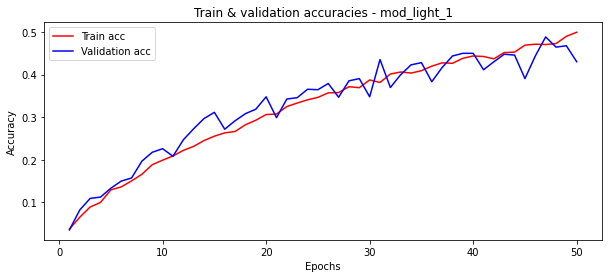

In [32]:
modelize(model_1, 50, train_gen_1, val_gen_1,  TRAIN_STEPS_light, VAL_STEPS_light, "mod_light_1")

## **Modèle 2, structure différente - light**<br><br>Comme observé sur certains modèles, on augmente le nombre de filtres des couches de convolutions...




In [33]:
def create_model_2():

    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape = (100,100, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(30))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))

    model.add(Dense(30))
    model.add(Activation("softmax"))

    return model

In [34]:
model_2 = create_model_2()
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_36 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_37 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 32)       

Temps d'entrainements pour 50 epochs : 855 secondes.
Meilleure train_acc = 0.59, meilleure val_acc = 0.52



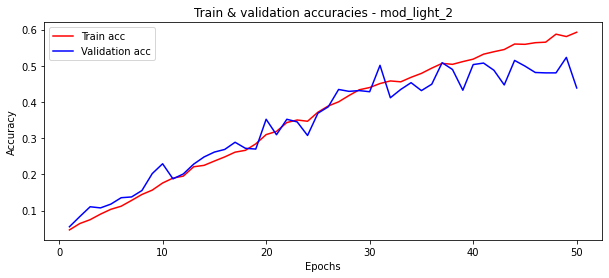

In [37]:
modelize(model_2, 50, train_gen, val_gen,  TRAIN_STEPS_light, VAL_STEPS_light, "mod_light_2")

In [ ]:
# Léger mieux des résultats

Même type de courbe avec un léger décrochement de la val_acc (début d'overfitting...).<br>Par contre en lui même le changement de "structure" du réseau, avec une augmentation du nombre de filtres sur la fin de la partie convolution du modèle, produit une augmentation spectaculaire des résultats...

## **Modèle 3, - light**<br>On enlève le dernier maxpooling qui réduit trop la taille de l'output du bloc conv

In [38]:
def create_model_3():

    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape = (100,100, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(30))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))

    model.add(Dense(30))
    model.add(Activation("softmax"))

    return model

In [39]:
model_3 = create_model_3()
model_3.summary()
# ca va doubler le nb de paramètres du modèle...

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_42 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_43 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 23, 23, 32)       

In [ ]:
# augmentation du nb de paramètres à entrainer

Found 4917 images belonging to 30 classes.
Found 4917 images belonging to 30 classes.


Temps d'entrainements pour 60 epochs : 1024 secondes.
Meilleure train_acc = 0.84, meilleure val_acc = 0.75



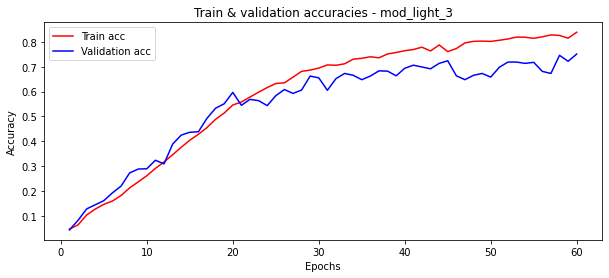

In [40]:
modelize(model_3, 60, train_gen, val_gen,  TRAIN_STEPS_light, VAL_STEPS_light, "mod_light_3")

In [ ]:
# mieux spectaculaire des résultats, la taille d'output de la partie convo était trop petite...

## **Modèle 4, - light**<br>Global Max Pooling

In [46]:
def create_model_4():

    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape = (100,100, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    #model.add(Flatten())
    model.add(GlobalMaxPool2D())

    model.add(Dense(30))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))

    model.add(Dense(30))
    model.add(Activation("softmax"))

    return model

In [47]:
model_4 = create_model_4()
model_4.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_52 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_53 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 23, 23, 32)       

Temps d'entrainements pour 50 epochs : 859 secondes.
Meilleure train_acc = 0.54, meilleure val_acc = 0.46



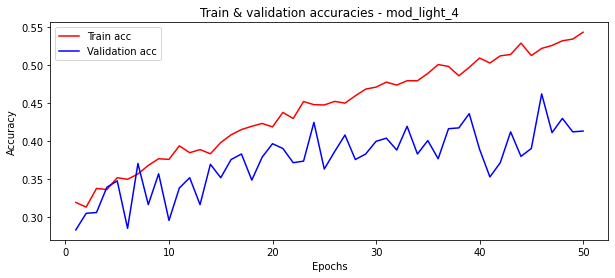

In [49]:
modelize(model_4, 50, train_gen, val_gen,  TRAIN_STEPS_light, VAL_STEPS_light, "mod_light_4")

In [ ]:
# Foireux

## **Modèle 5, - changement d'optimizer** et retour model_3

In [50]:
model_5 = create_model_3()
model_5.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_58 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_59 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 23, 23, 32)      

Temps d'entrainements pour 50 epochs : 853 secondes.
Meilleure train_acc = 0.86, meilleure val_acc = 0.81



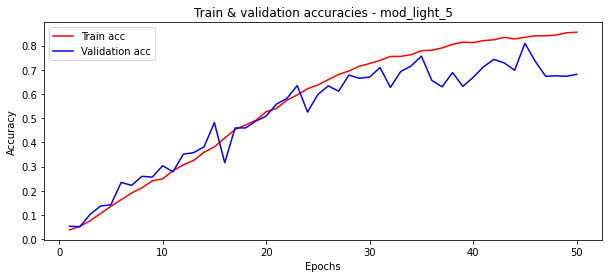

In [51]:
modelize(model_5, 50, train_gen, val_gen,  TRAIN_STEPS_light, VAL_STEPS_light, "mod_light_5", "RMSprop")

In [ ]:
# Meilleur résultats 81 !!! On va garder l'optimisation "RMSprop"

## **Modèle 6, - batch 64** et retour model_3

In [52]:
## **Modèle 6, - batch 64**

In [56]:
BATCH = 64
SEED = 47
NB_TRAIN = 74137 # nb original
NB_TRAIN_light = 4917 # nb original

TRAIN_STEPS = NB_TRAIN // BATCH
TRAIN_STEPS_light = NB_TRAIN_light // BATCH

VAL_STEPS = TRAIN_STEPS // 5
VAL_STEPS_light = TRAIN_STEPS_light // 5

train_gen_6, val_gen_6 = create_generator(BATCH, PATH_TRAIN_l)

Found 4917 images belonging to 30 classes.
Found 4917 images belonging to 30 classes.


In [58]:
model_6 = create_model_3()

Temps d'entrainements pour 50 epochs : 847 secondes.
Meilleure train_acc = 0.85, meilleure val_acc = 0.78



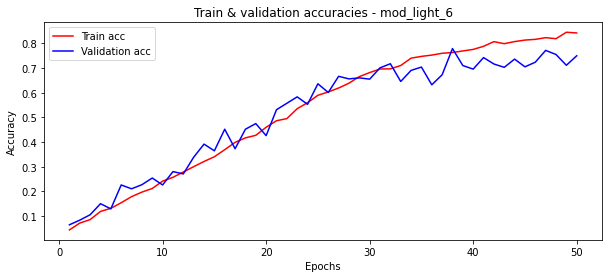

In [59]:
modelize(model_6, 50, train_gen_6, val_gen_6,  TRAIN_STEPS_light, VAL_STEPS_light, "mod_light_6", "RMSprop")

### Full model

Model_3 + rmsprop + couches à 120 classes + full training

In [60]:
def create_model_3_full():

    model = Sequential()

    model.add(Conv2D(32, (3,3), input_shape = (100,100, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64, (3,3)))
    model.add(Activation("relu"))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Flatten())

    model.add(Dense(120))
    model.add(Activation("relu"))
    model.add(Dropout(0.1))

    model.add(Dense(120))
    model.add(Activation("softmax"))

    return model

In [61]:
model_3_full = create_model_3_full()
model_3_full.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_76 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_57 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_77 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 23, 23, 32)      

In [62]:
BATCH = 32
SEED = 47
NB_TRAIN = 74137 # nb original
NB_TRAIN_light = 4917 # nb original

TRAIN_STEPS = NB_TRAIN // BATCH
TRAIN_STEPS_light = NB_TRAIN_light // BATCH

VAL_STEPS = TRAIN_STEPS // 5
VAL_STEPS_light = TRAIN_STEPS_light // 5


train_gen_full, val_gen_full = create_generator(BATCH, PATH_TRAIN)

Found 74137 images belonging to 120 classes.
Found 74137 images belonging to 120 classes.


Epoch 1/5
2316/2316 [==============================] - 219s 94ms/step - loss: 3.2931 - accuracy: 0.2156 - val_loss: 3.6329 - val_accuracy: 0.1913
Epoch 2/5
2316/2316 [==============================] - 218s 94ms/step - loss: 3.2749 - accuracy: 0.2173 - val_loss: 3.4021 - val_accuracy: 0.2055
Epoch 3/5
2316/2316 [==============================] - 217s 94ms/step - loss: 3.3206 - accuracy: 0.2141 - val_loss: 3.3950 - val_accuracy: 0.1969
Epoch 4/5
2316/2316 [==============================] - 219s 94ms/step - loss: 3.3496 - accuracy: 0.2056 - val_loss: 3.3021 - val_accuracy: 0.2118
Epoch 5/5
2316/2316 [==============================] - 218s 94ms/step - loss: 3.3822 - accuracy: 0.2047 - val_loss: 3.3230 - val_accuracy: 0.2103
Temps d'entrainements pour 5 epochs : 1090 secondes.
Meilleure train_acc = 0.21, meilleure val_acc = 0.21



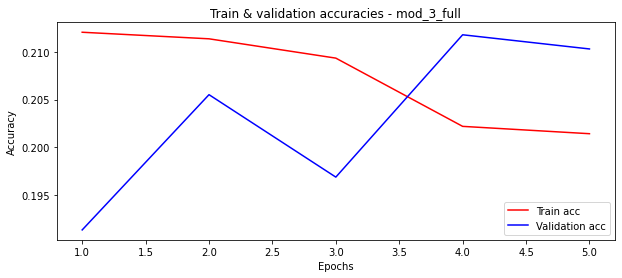

In [66]:
modelize(model_3_full, 5, train_gen_full, val_gen_full,  TRAIN_STEPS, VAL_STEPS, "mod_3_full", "RMSprop", 1)

In [ ]:
# à 220 sec l'epoch, on part sur du 3h d'entrainement pour du 50 epochs, faire modélisation en fin de projet...

In [69]:
(50*220)/3600

3.0555555555555554